# tensorflow 线性回归 

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
# creat data
x_data = np.random.rand(100).astype(np.float32)
y_data = x_data * 0.1 + 0.3

In [5]:
### creat tensorflow structure start ###
Weights = tf.Variable(tf.random_uniform([1],-1.0,1.0))  #生成一维变量(-1,1)
biases = tf.Variable(tf.zeros([1]))

y = Weights * x_data + biases

loss = tf.reduce_mean(tf.square(y - y_data))
optimizer = tf.train.GradientDescentOptimizer(0.5)   #建立优化器(学习率)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()    #变量初始化
#init = tf.initialize_all_variables()    
### creat tensorflow structure end ###

In [6]:
sess = tf.Session()
sess.run(init)   #激活init

for step in range(201):
    sess.run(train)
    if step % 20 == 0:
        print(step,sess.run(Weights),sess.run(biases))

0 [-0.12793511] [0.5822742]
20 [0.01123885] [0.34734496]
40 [0.07326261] [0.31426167]
60 [0.09194595] [0.30429602]
80 [0.09757389] [0.3012941]
100 [0.09926917] [0.30038983]
120 [0.09977985] [0.30011743]
140 [0.0999337] [0.3000354]
160 [0.09998003] [0.30001065]
180 [0.099994] [0.30000323]
200 [0.09999821] [0.30000097]


# Session会话控制

In [7]:
import tensorflow as tf

In [8]:
matrix1 = tf.constant([[3,3]])
matrix2 = tf.constant([[2],
                       [2]])
product = tf.matmul(matrix1,matrix2)    #matrix multiply输入必须是矩阵，等同于np.dot(m1,m2)

In [9]:
### method 1 手动关闭###
sess = tf.Session()
result = sess.run(product)
print(result)
sess.close()

[[12]]


In [10]:
### method 2 在with中自动关闭###
with tf.Session() as sess:
    result2 = sess.run(product)
    print(result2)

[[12]]


# 变量

In [12]:
state = tf.Variable(0,name = 'counter')
print(state.name)

counter_1:0


In [14]:
one = tf.constant(1)
new_value = tf.add(state,one)   #变量加常量结果是变量
update = tf.assign(state,new_value)    #把new_value的值加载到state上

init = tf.initialize_all_variables()   #定义变量一定要初始化

In [15]:
with tf.Session() as sess:    #在session中开始执行
    sess.run(init)
    for _ in range(3):
        sess.run(update)
        print(sess.run(state))

1
2
3


# 传入值placeholder

In [22]:
input1 = tf.placeholder(tf.float32)    #tf.placeholder(type)
input2 = tf.placeholder(tf.float32)

output = tf.multiply(input1,input2)    #tf.multiply()矩阵中元素对应相乘

In [23]:
with tf.Session() as sess:     #feed_dict给placeholder传值
    print(sess.run(output,feed_dict={input1:[7.],input2:[2.]})) 

[14.]


# activation function 激活函数

### tf.nn.relu(features,name = None)
### tf.nn.relu6(features,name = None)
### tf.nn.softplus(features,name = None)
### tf.nn.dropout(x,keep_prob,noise_shape=None,seed=None,name = None)
### tf.nn.bias_add(values,bias,name = None)
### tf.sigmoid(x,name=None)
### tf.tanh(x,name=None)

# 添加层

In [66]:
def add_layer(inputs,in_size,out_size,n_layer,activation_function=None):
    layer_name = 'layer%s'% n_layer
    with tf.name_scope(layer_name):
        with tf.name_scope('weights'):
            Weights = tf.Variable(tf.random_normal([in_size,out_size]),name='W')
            tf.summary.histogram(layer_name+'/weights',Weights)
        with tf.name_scope('biases'):
            biases = tf.Variable(tf.zeros([1,out_size]) + 0.1)
            tf.summary.histogram(layer_name+'/biases',biases)
        with tf.name_scope('Wx_plus_b'):
            Wx_plus_b = tf.add(tf.matmul(inputs,Weights), biases)
        if activation_function is None:
            outputs = Wx_plus_b
        else:
            outputs = activation_function(Wx_plus_b)    #用非线性激活函数处理输出值
        tf.summary.histogram(layer_name+'/outputs',outputs)
        return outputs

# 构建神经网络 + 可视化(在Jupyter中无法动态展示)

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline

x_data = np.linspace(-1,1,300)[:,np.newaxis]  #np.newaxis在其所在的位置增加一个维度
noise = np.random.normal(0,0.05,x_data.shape) #np.random.normal(均值，方差，格式)
y_data = np.square(x_data) - 0.5 + noise      #真实y值

with tf.name_scope('inputs'):
    xs = tf.placeholder(tf.float32,[None,1],name='x_input')    #[None,1]指行不定一列
    ys = tf.placeholder(tf.float32,[None,1],name='y_input')    #name在图层中展示

In [77]:
###定义隐藏层
layer1 = add_layer(xs,1,10,activation_function=tf.nn.relu)
prediction = add_layer(layer1,10,1,activation_function=None)
with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.reduce_sum(tf.square(ys - prediction),reduction_indices=[1]))
    tf.summary.scalar('loss',loss)

In [78]:
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

init = tf.global_variables_initializer()      #变量初始化

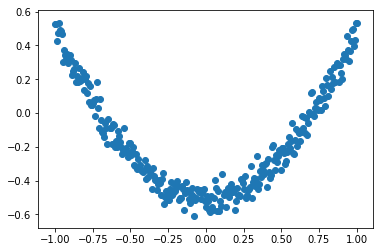

In [79]:
sess = tf.Session()
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter('logs/',sess.graph)   #将框架写入文件中
sess.run(init)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(x_data,y_data)
plt.ion()    #绘图后不暂停
plt.show()   

for i in range(1000):
    sess.run(train_step,feed_dict={xs:x_data,ys:y_data})
    if i % 50 == 0:
        result = sess.run(merged,feed_dict={xs:x_data,ys:y_data})
        writer.add_summary(result,i)
        #print(sess.run(loss,feed_dict={xs:x_data,ys:y_data}))
        try:
            ax.lines.remove(lines[0])   #先抹除第一条线
        except Exception:
            pass
        prediction_value = sess.run(prediction,feed_dict={xs:x_data})
        lines = ax.plot(x_data,prediction_value,'r-',lw=5)    #画出预测值和自变量的曲线
        plt.pause(0.1)        

# optimizer优化器

### tf.train. GradientDescentOptimizer
### tf.train. AdadeltaOptimizer
### tf.train. AdagradOptimizer
### tf.train. MomentumOptimizer
### tf.train. AdamOptimizer
### tf.train. FtrlOptimizer
### tf.train. RMSPropOptimizer